In [1]:
import sys
print(sys.executable)

c:\Program Files\Python311\python.exe


In [7]:
#all genes

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from tensorflow.keras.optimizers import Adam
import numpy as np
import time
import pandas as pd

seed = 0
np.random.seed(seed)

# Load data
X_train = pd.read_csv("X_train_Norway.csv")
X_test = pd.read_csv("X_test_Norway.csv")
y_train = pd.read_csv("y_train_Norway.csv").values.ravel()
y_test = pd.read_csv("y_test_Norway.csv").values.ravel()


# Label encode
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Get number of classes and input dimension
n_classes = len(np.unique(y_train_enc))
input_dim = X_train.shape[1]

print(f"Input dimensions: {input_dim}")
print(f"Number of classes: {n_classes}")

# Create function to build neural network with more options
def create_nn(meta, neurons_layer1=256, neurons_layer2=128, dropout_rate1=0.3, dropout_rate2=0.3, 
              learning_rate=0.002, activation='relu', regularization=None):
    
    # Set regularizer
    if regularization == 'l1':
        reg = l1(1e-15)
    elif regularization == 'l2':
        reg = l2(1e-15)
    elif regularization == 'l1_l2':
        reg = l1_l2(l1=1e-15, l2=1e-15)
    else:
        reg = None

    # Get input dimensions from meta
    n_features_in = meta["n_features_in_"]
    n_classes = meta["n_classes_"]
    
    # Build model
    model = Sequential([
        Dense(neurons_layer1, activation=activation, kernel_regularizer=reg, 
              input_shape=(n_features_in,)),  # Adjust based on feature selection
        BatchNormalization(),
        Dropout(dropout_rate1),
        Dense(neurons_layer2, activation=activation, kernel_regularizer=reg),
        BatchNormalization(),
        Dropout(dropout_rate2),
        Dense(n_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap model
nn_model = KerasClassifier(
    model=create_nn, 
    epochs=100, 
    batch_size=16, 
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Pipeline with feature selection
pipeline = ImbPipeline([
    ('irus', RandomUnderSampler(random_state=seed)),
    ('nn', nn_model)
])

# Parameter grid based on the paper
param_grid = {
    # Best from paper: None, ReLU, 0.002, 16, 0.3
    'nn__model__regularization': [None, 'l1', 'l2', 'l1_l2'],
    'nn__model__activation': ['relu', 'tanh', LeakyReLU(negative_slope=0.01)],
    'nn__model__learning_rate': [0.01, 0.002, 0.001, 0.0001, 0.00001, 0.000001],
    'nn__batch_size': [16, 32, 64, 128],
    'nn__model__dropout_rate1': [0.1, 0.2, 0.3],
    'nn__model__dropout_rate2': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Use RandomizedSearchCV to sample combinations
print("Starting hyperparameter search...")
print(f"Total possible combinations: {4 * 3 * 6 * 4 * 5 * 2 * 2} = {4*3*6*4*5*2*2}")
print("Testing 50 random combinations with 3-fold CV = 150 model trainings\n")

start_time = time.time()

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=50,  # Test 50 random combinations
    cv=2,  # 3-fold CV (paper uses 5-fold, but 3 is faster)
    scoring='f1_weighted',
    n_jobs=1,  # Use 1 to avoid issues with Keras
    verbose=3,  # Maximum verbosity for progress tracking
    random_state=seed,
    return_train_score=True
)

# Fit with progress tracking
grid_search.fit(X_train, y_train_enc)

end_time = time.time()
elapsed_time = (end_time - start_time) / 60  # Convert to minutes

# Results
print("\n" + "="*80)
print("SEARCH COMPLETE!")
print("="*80)
print(f"\nTotal time: {elapsed_time:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")

# Test on held-out test set
test_acc = grid_search.score(X_test, y_test_enc)
print(f"Test set accuracy: {test_acc:.4f}")

# Create results dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')

# Show top 10 configurations
print("\n" + "="*80)
print("TOP 10 CONFIGURATIONS:")
print("="*80)
top_10 = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].head(10)
for idx, row in top_10.iterrows():
    print(f"\nRank {int(row['rank_test_score'])}:")
    print(f"  Accuracy: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print(f"  Parameters: {row['params']}")

# Save results to CSV
results_df.to_csv('nn_hyperparameter_search_results.csv', index=False)
print("\n" + "="*80)
print("Full results saved to 'nn_hyperparameter_search_results.csv'")
print("="*80)

Input dimensions: 20789
Number of classes: 5
Starting hyperparameter search...
Total possible combinations: 5760 = 5760
Testing 50 random combinations with 3-fold CV = 150 model trainings

Fitting 2 folds for each of 50 candidates, totalling 100 fits


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.024, test=0.050) total time=   9.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.288, test=0.354) total time=   9.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.032, test=0.027) total time=  11.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.339, test=0.348) total time=  13.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.032, test=0.027) total time=  10.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.325, test=0.326) total time=  10.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.104, test=0.067) total time=  11.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.084, test=0.101) total time=  12.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.195, test=0.085) total time=  13.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.050, test=0.024) total time=  13.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.100, test=0.085) total time=  12.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.004, test=0.004) total time=  11.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.663, test=0.400) total time=  12.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.163, test=0.103) total time=  11.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.103, test=0.049) total time=  14.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.107, test=0.104) total time=  12.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.281, test=0.257) total time=  12.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=None;, score=(train=0.037, test=0.052) total time=  11.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.100, test=0.085) total time=  11.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.004, test=0.004) total time=  11.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.023, test=0.004) total time=  12.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=None;, score=(train=0.340, test=0.340) total time=  12.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.504, test=0.401) total time=  12.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.516, test=0.408) total time=  15.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.281, test=0.257) total time=  13.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=l1;, score=(train=0.353, test=0.255) total time=  17.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.338, test=0.277) total time=  13.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.022, test=0.004) total time=  14.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.111, test=0.101) total time=  14.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=1e-06, nn__model__regularization=l1_l2;, score=(train=0.072, test=0.076) total time=  12.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.024, test=0.050) total time=  12.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.034, test=0.035) total time=  10.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.100, test=0.085) total time=  12.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.004, test=0.004) total time=  14.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.032, test=0.027) total time=  10.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.257, test=0.281) total time=  10.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.100, test=0.085) total time=  13.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.004, test=0.004) total time=  13.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.218, test=0.181) total time=  11.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.004, test=0.004) total time=  12.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.475, test=0.275) total time=  11.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l2;, score=(train=0.085, test=0.100) total time=  12.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.051, test=0.027) total time=  13.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1;, score=(train=0.004, test=0.004) total time=  13.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.110, test=0.102) total time=  13.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.094, test=0.051) total time=  12.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.587, test=0.447) total time=  15.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.506, test=0.314) total time=  14.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.100, test=0.085) total time=  15.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.1, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.004, test=0.004) total time=  14.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.412, test=0.312) total time=  12.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-05, nn__model__regularization=None;, score=(train=0.022, test=0.004) total time=  11.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.281, test=0.257) total time=  10.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.085, test=0.100) total time=   9.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.043, test=0.050) total time=  14.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1_l2;, score=(train=0.027, test=0.032) total time=  15.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.703, test=0.428) total time=  11.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1_l2;, score=(train=0.370, test=0.221) total time=  14.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.207, test=0.097) total time=  17.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.349, test=0.232) total time=  22.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.500, test=0.402) total time=  10.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.085, test=0.100) total time=  11.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.032, test=0.027) total time=  10.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.085, test=0.100) total time=  10.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.100, test=0.085) total time=  13.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.01, nn__model__regularization=l2;, score=(train=0.004, test=0.004) total time=  12.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.161, test=0.085) total time=  12.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=relu, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.277, test=0.281) total time=  12.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.004, test=0.004) total time=  13.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.2, nn__model__learning_rate=0.001, nn__model__regularization=l2;, score=(train=0.257, test=0.281) total time=  12.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.179, test=0.039) total time=  10.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.01, nn__model__regularization=l1;, score=(train=0.205, test=0.173) total time=  11.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.150, test=0.085) total time=  10.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.106, test=0.091) total time=  10.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.540, test=0.374) total time=  13.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.409, test=0.355) total time=  11.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.032, test=0.027) total time=  12.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=None;, score=(train=0.235, test=0.220) total time=  13.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.637, test=0.443) total time=  15.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.234, test=0.126) total time=  14.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.334, test=0.233) total time=  14.2s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.01, nn__model__regularization=l1_l2;, score=(train=0.027, test=0.032) total time=  14.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.455, test=0.367) total time=  12.1s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.146, test=0.163) total time=  11.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.283, test=0.259) total time=  14.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=relu, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=1e-06, nn__model__regularization=l2;, score=(train=0.268, test=0.336) total time=  12.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.415, test=0.309) total time=  11.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.040, test=0.004) total time=  12.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1;, score=(train=0.302, test=0.257) total time=  12.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=tanh, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.001, nn__model__regularization=l1;, score=(train=0.522, test=0.437) total time=  13.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.443, test=0.257) total time=  12.3s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.2, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.0001, nn__model__regularization=l1;, score=(train=0.338, test=0.047) total time=  13.9s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.103, test=0.050) total time=  14.7s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=32, nn__model__activation=<LeakyReLU name=leaky_re_lu, built=True>, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.3, nn__model__learning_rate=0.002, nn__model__regularization=l1_l2;, score=(train=0.004, test=0.004) total time=  14.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.025, test=0.054) total time=  12.8s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=64, nn__model__activation=relu, nn__model__dropout_rate1=0.1, nn__model__dropout_rate2=0.5, nn__model__learning_rate=1e-06, nn__model__regularization=l1;, score=(train=0.257, test=0.281) total time=  14.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.050, test=0.027) total time=  12.5s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=16, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.4, nn__model__learning_rate=0.002, nn__model__regularization=l2;, score=(train=0.037, test=0.038) total time=  11.0s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.004, test=0.004) total time=  12.4s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/2] END nn__batch_size=128, nn__model__activation=tanh, nn__model__dropout_rate1=0.3, nn__model__dropout_rate2=0.5, nn__model__learning_rate=0.01, nn__model__regularization=None;, score=(train=0.277, test=0.281) total time=  10.6s


C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



SEARCH COMPLETE!

Total time: 21.88 minutes

Best parameters found:
  nn__model__regularization: None
  nn__model__learning_rate: 1e-05
  nn__model__dropout_rate2: 0.4
  nn__model__dropout_rate1: 0.2
  nn__model__activation: tanh
  nn__batch_size: 128

Best cross-validation accuracy: 0.4042
Test set accuracy: 0.0692

TOP 10 CONFIGURATIONS:

Rank 1:
  Accuracy: 0.4042 (+/- 0.0034)
  Parameters: {'nn__model__regularization': None, 'nn__model__learning_rate': 1e-05, 'nn__model__dropout_rate2': 0.4, 'nn__model__dropout_rate1': 0.2, 'nn__model__activation': 'tanh', 'nn__batch_size': 128}

Rank 2:
  Accuracy: 0.3805 (+/- 0.0662)
  Parameters: {'nn__model__regularization': None, 'nn__model__learning_rate': 1e-05, 'nn__model__dropout_rate2': 0.2, 'nn__model__dropout_rate1': 0.1, 'nn__model__activation': 'tanh', 'nn__batch_size': 128}

Rank 3:
  Accuracy: 0.3646 (+/- 0.0096)
  Parameters: {'nn__model__regularization': 'l1', 'nn__model__learning_rate': 0.0001, 'nn__model__dropout_rate2': 0.5, '


Test Accuracy (Best Neural Network): 0.0692

Classification Report (Best Neural Network):
              precision    recall  f1-score   support

       Basal       0.00      0.00      0.00         7
        Her2       0.33      0.14      0.20         7
        LumA       0.00      0.00      0.00        23
        LumB       1.00      0.08      0.15        12
      Normal       0.06      1.00      0.12         3

    accuracy                           0.10        52
   macro avg       0.28      0.25      0.09        52
weighted avg       0.28      0.10      0.07        52



C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

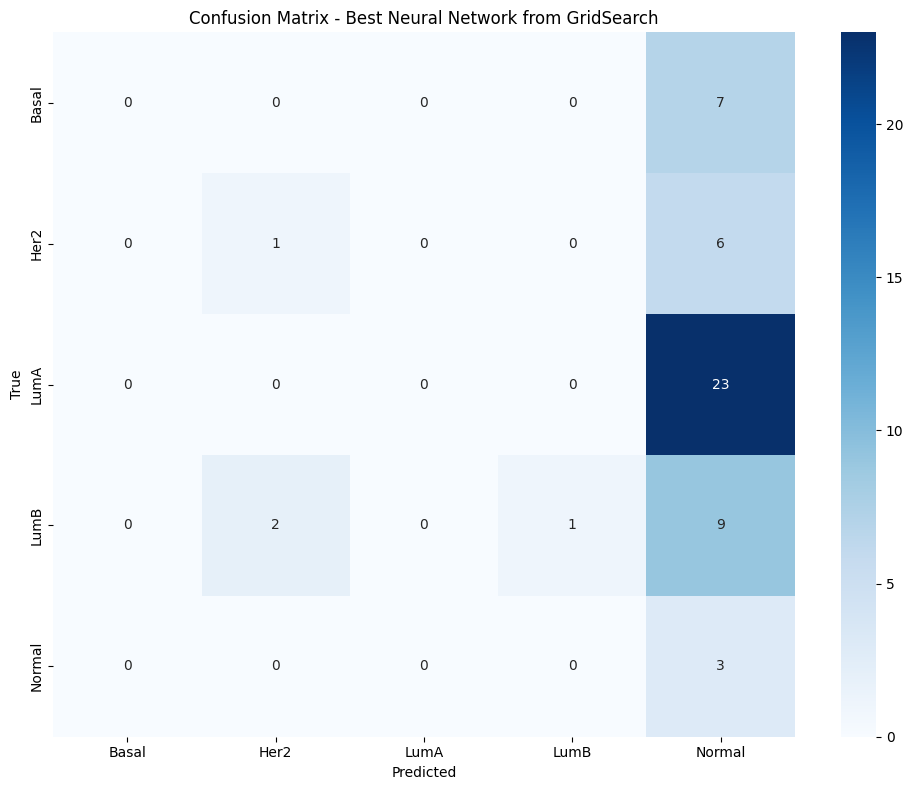

C:\Users\mike\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Retraining best model to visualize training history...


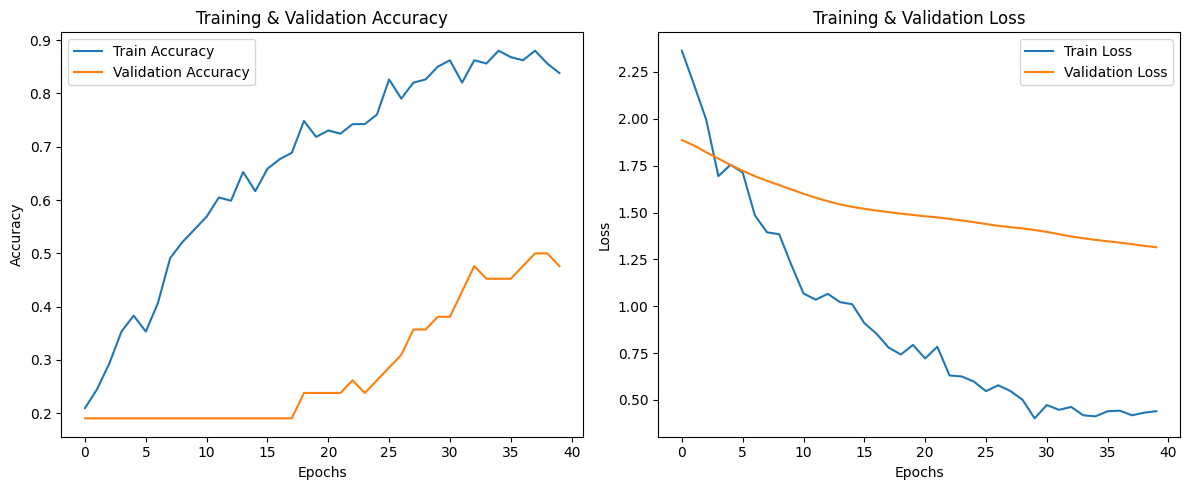

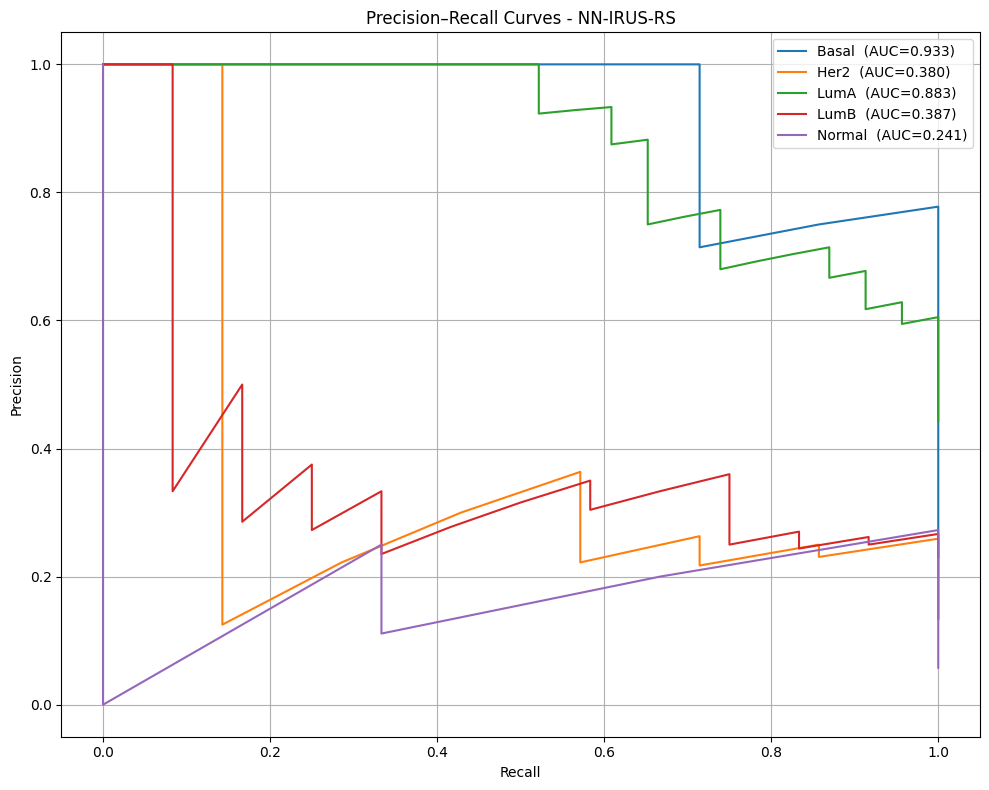

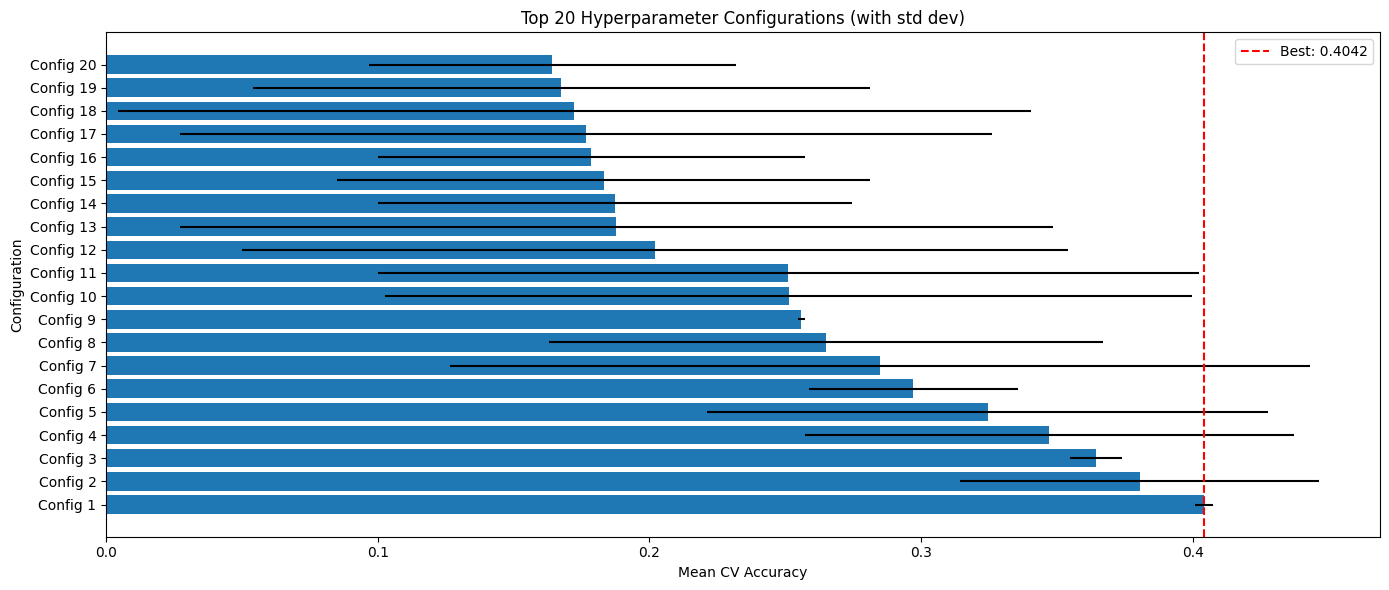


HYPERPARAMETER ANALYSIS:

nn__model__regularization:
  l1: appears 5/10 times in top 10
  None: appears 2/10 times in top 10
  l1_l2: appears 2/10 times in top 10
  l2: appears 1/10 times in top 10

nn__model__activation:
  tanh: appears 8/10 times in top 10
  relu: appears 1/10 times in top 10
  <LeakyReLU name=leaky_re_lu, built=True>: appears 1/10 times in top 10

nn__model__learning_rate:
  0.0001: appears 4/10 times in top 10
  1e-05: appears 3/10 times in top 10
  0.001: appears 1/10 times in top 10
  1e-06: appears 1/10 times in top 10
  0.002: appears 1/10 times in top 10

nn__batch_size:
  128: appears 3/10 times in top 10
  64: appears 3/10 times in top 10
  32: appears 2/10 times in top 10
  16: appears 2/10 times in top 10

nn__model__dropout_rate:


KeyError: 'nn__model__dropout_rate'

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve,average_precision_score
from sklearn.preprocessing import label_binarize
import pandas as pd
from collections import Counter

# Evaluate on test set using best model from grid search
test_acc = grid_search.score(X_test, y_test_enc)

print(f"\nTest Accuracy (Best Neural Network): {test_acc:.4f}")

# Predict using best model
y_pred_classes = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)


# Classification report
print("\nClassification Report (Best Neural Network):")
print(classification_report(y_test_enc, y_pred_classes, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test_enc, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Best Neural Network from GridSearch')
plt.tight_layout()
plt.show()

print("\nRetraining best model to visualize training history...")

best_params = grid_search.best_params_

meta = {
    "n_features_in_": X_train.shape[1],
    "n_classes_": len(np.unique(y_train_enc))
}

best_model = create_nn(
    meta=meta,
    neurons_layer1=best_params.get('nn__model__neurons_layer1', 256),
    neurons_layer2=best_params.get('nn__model__neurons_layer2', 128),
    dropout_rate1=best_params['nn__model__dropout_rate1'],
    dropout_rate2=best_params['nn__model__dropout_rate2'],
    learning_rate=best_params['nn__model__learning_rate'],
    activation=best_params['nn__model__activation'],
    regularization=best_params['nn__model__regularization']
)

history = best_model.fit(
    X_train, y_train_enc,
    validation_split=0.2,
    epochs=100,
    batch_size=best_params['nn__batch_size'],
    verbose=0,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
)

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# -------------------------------
# PRECISION–RECALL CURVES
# -------------------------------
# Binarize true labels
y_test_binarized = label_binarize(y_test_enc, classes=np.arange(len(le.classes_)))

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(le.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f"{class_name}  (AUC={auc_score:.3f})")


plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - NN-IRUS-RS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# GridSearch Results Visualization
# ------------------------------------------------------------------

results_df = pd.DataFrame(grid_search.cv_results_)

# Plot top 20 configurations
plt.figure(figsize=(14, 6))
top_20 = results_df.nsmallest(20, 'rank_test_score')

plt.barh(range(len(top_20)), top_20['mean_test_score'], xerr=top_20['std_test_score'])
plt.yticks(range(len(top_20)), [f"Config {i+1}" for i in range(len(top_20))])
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Configuration')
plt.title('Top 20 Hyperparameter Configurations (with std dev)')
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', label=f'Best: {grid_search.best_score_:.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Hyperparameter importance analysis
# ------------------------------------------------------------------

print("\n" + "="*80)
print("HYPERPARAMETER ANALYSIS:")
print("="*80)

top_10_configs = results_df.nsmallest(10, 'rank_test_score')

for param in ['nn__model__regularization', 'nn__model__activation', 
              'nn__model__learning_rate', 'nn__batch_size', 'nn__model__dropout_rate']:
    print(f"\n{param}:")
    param_values = [config[param] for config in top_10_configs['params']]
    counts = Counter(param_values)
    for value, count in counts.most_common():
        print(f"  {value}: appears {count}/10 times in top 10")

# ------------------------------------------------------------------
# CV Accuracy Distribution
# ------------------------------------------------------------------

plt.figure(figsize=(12, 5))

# Histogram of all CV accuracies
plt.subplot(1, 2, 1)
plt.hist(results_df['mean_test_score'], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(x=grid_search.best_score_, color='r', linestyle='--', 
            label=f'Best: {grid_search.best_score_:.4f}')
plt.xlabel('Mean CV Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of CV Accuracies Across All Configurations')
plt.legend()

# Box plot (adjust to number of folds)
plt.subplot(1, 2, 2)
n_folds = grid_search.cv  # dynamically use actual folds
cv_scores = [results_df[f'split{i}_test_score'] for i in range(n_folds)]
plt.boxplot(cv_scores, labels=[f'Fold {i+1}' for i in range(n_folds)])
plt.ylabel('Accuracy')
plt.title('CV Accuracy Distribution per Fold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# Summary statistics
# ------------------------------------------------------------------

print("\n" + "="*80)
print("SUMMARY STATISTICS:")
print("="*80)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Mean CV Accuracy (all configs): {results_df['mean_test_score'].mean():.4f}")
print(f"Std CV Accuracy (all configs): {results_df['mean_test_score'].std():.4f}")
print(f"Min CV Accuracy: {results_df['mean_test_score'].min():.4f}")
print(f"Max CV Accuracy: {results_df['mean_test_score'].max():.4f}")


In [14]:
rf = best_model.named_steps['rf']

if len(original_feature_names) != len(rf.feature_importances_):
    print(f"Warning: Number of feature names ({len(original_feature_names)}) doesn't match number of features used ({len(rf.feature_importances_)})")
    # Use generic names if there's a mismatch
    feature_names = [f'Feature {i}' for i in range(len(rf.feature_importances_))]
else:
    feature_names = original_feature_names

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 20 features
top_n = 20
plt.figure(figsize=(8, 6))
sns.barplot(data=feature_importance.head(top_n), x='Importance', y='Feature')
plt.title(f'Top {top_n} Most Important Features')
plt.tight_layout()
plt.show()

print("Top 20 features by importance:")
print(feature_importance['Feature'].head(20).tolist())

AttributeError: 'Sequential' object has no attribute 'named_steps'